In [1]:
import csv
import os
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from tqdm import tqdm_notebook
import scipy.stats as sstats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter, defaultdict
from itertools import cycle, combinations
from operator import itemgetter
from sklearn import datasets, metrics, tree
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn import datasets
from apyori import apriori
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from sklearn.decomposition import NMF, LatentDirichletAllocation
pd.options.mode.chained_assignment = None 
import numpy as np 
import pandas as pd 
from time import time
import re
import string
import os
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
cmaps = OrderedDict()
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


mpl.style.use('seaborn-pastel')
sns.set_style('whitegrid')

/home/julia/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
all_begs = ['product/productId: ', 'product/title: ', 
     'product/price: ', 'review/userId: ',
     'review/profileName: ', 'review/helpfulness: ',
     'review/score: ', 'review/time: ', 'review/summary: ',
     'review/text: ']
col_names = ['productID', 'title', 'price', 'userID', 'profileName', 'helpfulness', 'score',
                    'time', 'summary', 'text']

df = pd.read_csv("dataset.csv") 
df['time'] = pd.to_datetime(df['time'],unit='s')
df = df.drop(['profileName'], axis=1)
col_names.remove('profileName')
all_begs.remove('review/profileName: ')
df["summary"].fillna("none", inplace = True) 
df['summary_len'] = [len(summary) for summary in df['summary']]
df['text_len'] = [len(text) for text in df['text']]

In [20]:
df.groupby('score').count()['productID']

score
1.0    14675
2.0     7566
3.0     8719
4.0    17717
5.0    30253
Name: productID, dtype: int64

In [17]:
df.groupby('score').mean()

helpfulness  summary_len    text_len
score                                      
1.0       0.420694    24.534514  492.397479
2.0       0.440205    26.151335  618.803727
3.0       0.430210    26.153229  634.133272
4.0       0.455714    24.602867  658.935034
5.0       0.406484    22.810465  491.193501

I assume, that reviews with scores 5 and 4 are positive, 3 are neutral and reviews scored 1 or 2 are negative.

In [54]:
pos_op = df.loc[df['score'] >= 4]
neu_op = df.loc[df['score'] == 3]
neg_op = df.loc[df['score'] < 3]

In [61]:
pd.DataFrame(df.groupby(pd.cut(df.score, [0,2,3,5])).mean())

helpfulness     score  summary_len    text_len
score                                                 
(0, 2]     0.427331  1.340183    25.084529  535.398678
(2, 3]     0.430210  3.000000    26.153229  634.133272
(3, 5]     0.424666  4.630665    23.472462  553.146321

## Distribution of text lengths 

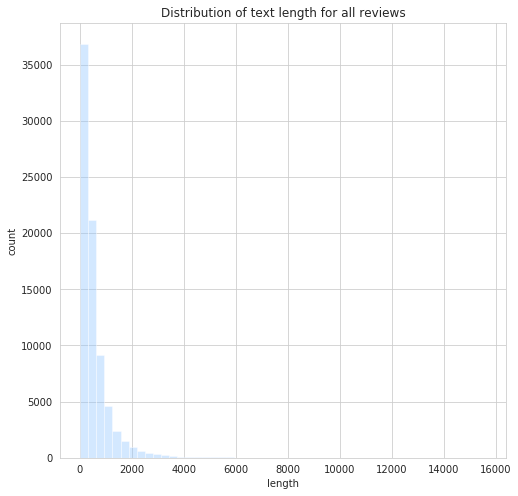

In [64]:
f, ax = plt.subplots(figsize=(8,8))
plt.ylabel('count')
sns.distplot(df['text_len'],kde=False)
plt.xlabel('length')
plt.title('Distribution of text length for all reviews')
plt.savefig('images/distlenall.png')
plt.show()

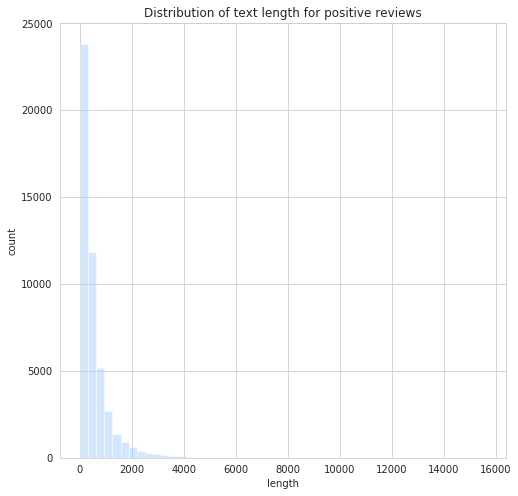

In [65]:
f, ax = plt.subplots(figsize=(8,8))
plt.ylabel('count')
sns.distplot(pos_op['text_len'],kde=False)
plt.xlabel('length')
plt.title('Distribution of text length for positive reviews')
plt.savefig('images/distlenpos.png')
plt.show()

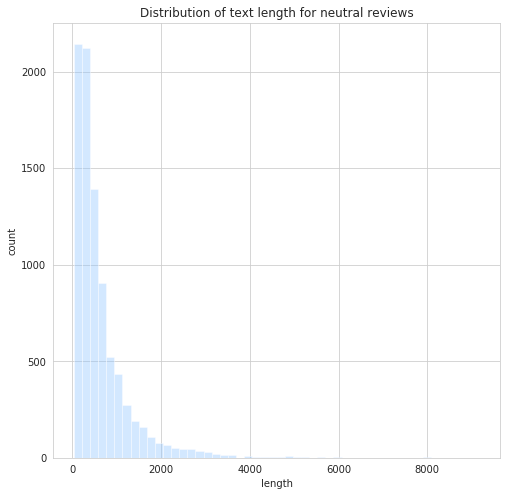

In [66]:
f, ax = plt.subplots(figsize=(8,8))
plt.ylabel('count')
sns.distplot(neu_op['text_len'],kde=False)
plt.xlabel('length')
plt.title('Distribution of text length for neutral reviews')
plt.savefig('images/distlenneu.png')
plt.show()

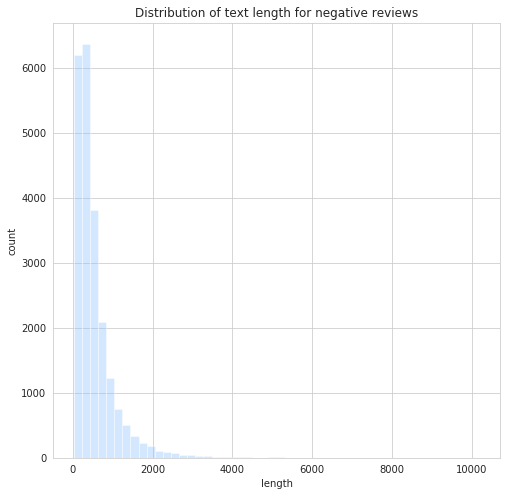

In [67]:
f, ax = plt.subplots(figsize=(8,8))
plt.ylabel('count')
sns.distplot(neg_op['text_len'],kde=False)
plt.xlabel('length')
plt.title('Distribution of text length for negative reviews')
plt.savefig('images/distlenneg.png')
plt.show()

# Most frequently occuring words in texts

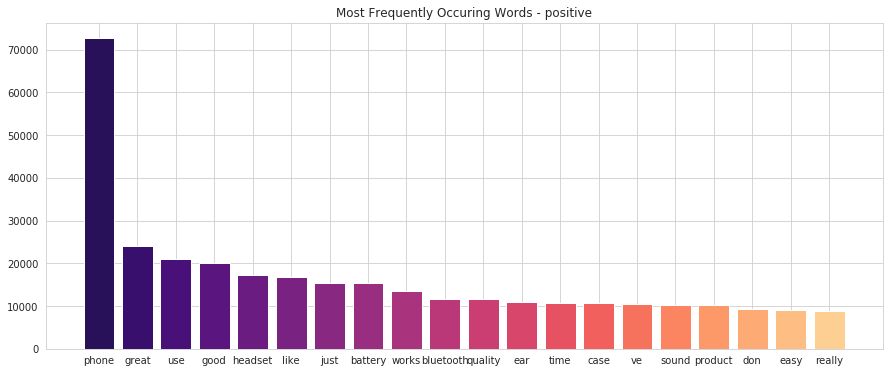

In [68]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(pos_op.text)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq).head(20)
plt.figure(figsize=(15,6))
plt.bar(frequency[0].values, frequency[1].values, color=plt.cm.magma(np.arange(40,240,10)))
plt.title("Most Frequently Occuring Words - positive")
plt.savefig('images/mostfreqpos.png')
plt.show()

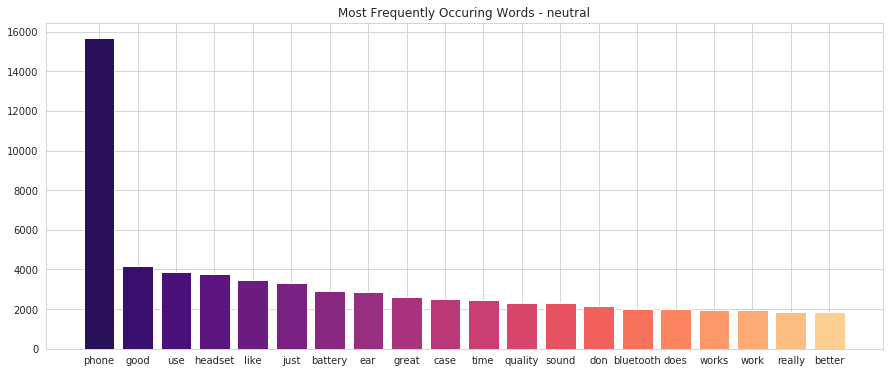

In [69]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(neu_op.text)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq).head(20)
plt.figure(figsize=(15,6))
plt.bar(frequency[0].values, frequency[1].values, color=plt.cm.magma(np.arange(40,240,10)))
plt.title("Most Frequently Occuring Words - neutral")
plt.savefig('images/mostfreqneu.png')
plt.show()

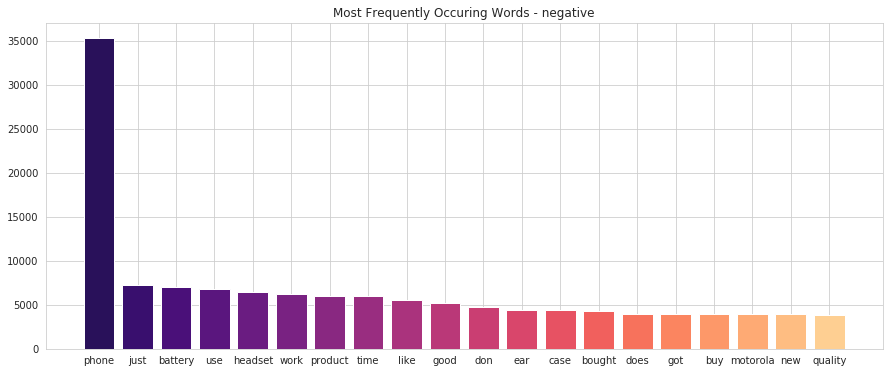

In [70]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(neg_op.text)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq).head(20)
plt.figure(figsize=(15,6))
plt.bar(frequency[0].values, frequency[1].values, color=plt.cm.magma(np.arange(40,240,10)))
plt.title("Most Frequently Occuring Words - negative")
plt.savefig('images/mostfreqneg.png')
plt.show()

# Most frequently occuring words in summaries

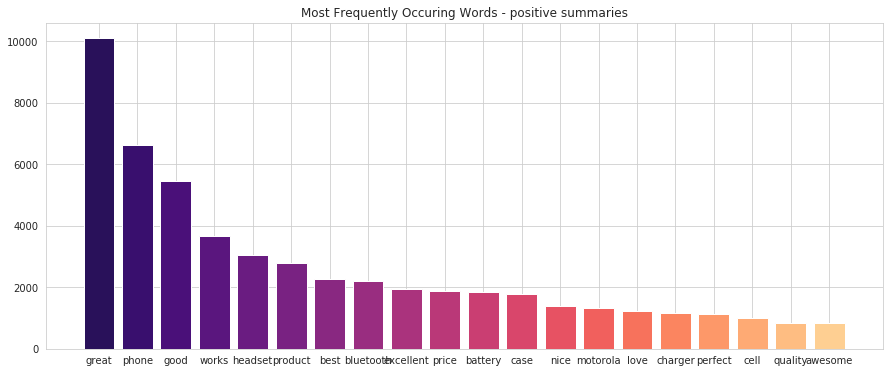

In [71]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(pos_op.summary)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq).head(20)
plt.figure(figsize=(15,6))
plt.bar(frequency[0].values, frequency[1].values, color=plt.cm.magma(np.arange(40,240,10)))
plt.title("Most Frequently Occuring Words - positive summaries")
plt.savefig('images/mostfreqpossum.png')
plt.show()

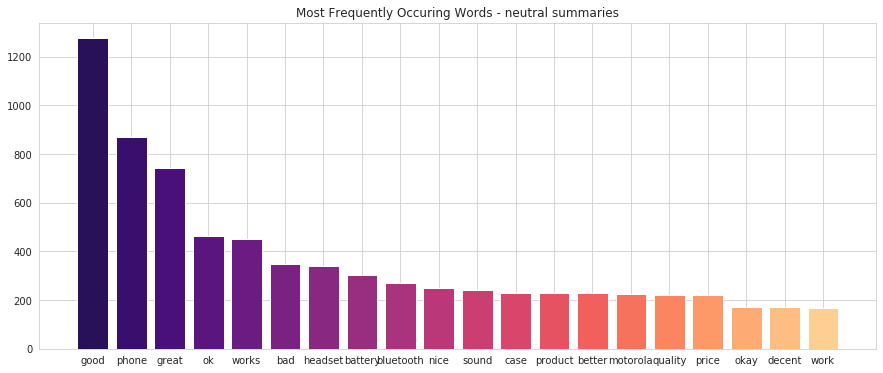

In [72]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(neu_op.summary)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq).head(20)
plt.figure(figsize=(15,6))
plt.bar(frequency[0].values, frequency[1].values, color=plt.cm.magma(np.arange(40,240,10)))
plt.title("Most Frequently Occuring Words - neutral summaries")
plt.savefig('images/mostfreqneusum.png')
plt.show()

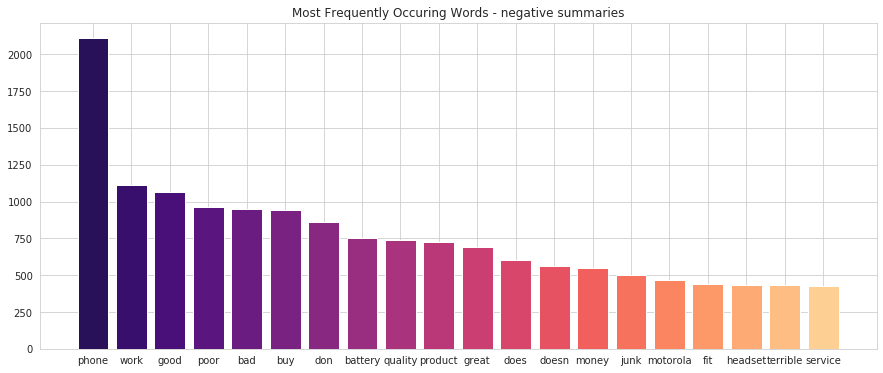

In [73]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(neg_op.summary)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq).head(20)
plt.figure(figsize=(15,6))
plt.bar(frequency[0].values, frequency[1].values, color=plt.cm.magma(np.arange(40,240,10)))
plt.title("Most Frequently Occuring Words - negative summaries")
plt.savefig('images/mostfreqnegsum.png')
plt.show()